In [1]:
import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler

import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [3]:
#removing outlier residuals

horror_df=horror_df.drop([681])
horror_df=horror_df.drop([682])
horror_df=horror_df.drop([683])
horror_df=horror_df.drop([668])

In [4]:
#sns.pairplot(horror_df,plot_kws=dict(alpha=.2,edgecolor='none'));

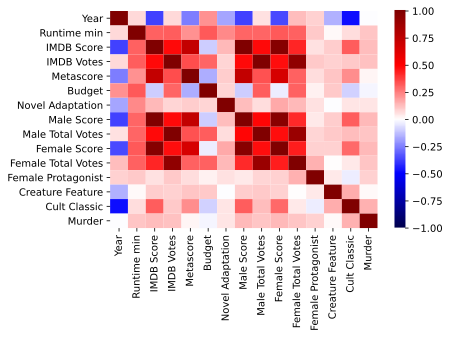

In [5]:
horror_df1=horror_df
horror_df1.columns = horror_df1.columns.str.replace('_',' ')
horror_df1.corr()
sns.heatmap(horror_df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
plt.savefig('horror_heatmap.svg',format='svg')

In [6]:
#selecting data to work with for regression
horror_df.columns = horror_df.columns.str.replace(' ','_')
X=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget']]
y=horror_df['Female_Score']

In [7]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,X],axis=1)
X=combined_X
y=horror_df['Female_Score']

In [8]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
X['Director']=horror_df['Director'].replace(other_d,'Other')
X=pd.get_dummies(X,drop_first=True)
y=horror_df['Female_Score']

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [10]:
#Initial linear model
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     4.549
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           1.17e-19
Time:                        11:01:55   Log-Likelihood:                -404.42
No. Observations:                 408   AIC:                             930.8
Df Residuals:                     347   BIC:                             1176.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           44.6490      4.972      8.980      0.000      34.870      54.428
 Adventure                       0.2217      0.298      0.744      0.458      -0.365       0.808
 Comedy                          0.2085      0.322      0.647      0.518      -0.425       0.842
 Comedy                          4.9416      0.740      6.677      0.000       3.486       6.397
 Crime                           0.5930      0.380      1.562      0.119      -0.154       1.340
 Crime                           4.4157      0.625      7.060      0.000       3.185       5.646
 Drama                           0.2909      0.248      1.174      0.241      -0.197       0.778
 Drama                           4.3691      0.616      7.089      0.000       3.157       5.581
 Family                         -0.3545      0.555     -0.639      0.523      -1.446       0.737
 Family                          5.1910      0.717      7.241      0.000       3.781       6.601
 Fantasy                         0.1652      0.191      0.863      0.389      -0.211       0.542
 Fantasy                         4.1515      0.532      7.803      0.000       3.105       5.198
 History                        -0.3419      0.772     -0.443      0.658      -1.860       1.176
 Horror                          2.8432      0.389      7.302      0.000       2.077       3.609
 Horror                          4.2321      0.520      8.140      0.000       3.210       5.255
 Music                           1.0080      0.743      1.357      0.176      -0.453       2.469
 Musical                         1.7066      0.844      2.023      0.044       0.047       3.366
 Musical                         2.1293      0.535      3.983      0.000       1.078       3.181
 Mystery                         0.0629      0.142      0.442      0.659      -0.217       0.343
 Mystery                         1.4340      0.248      5.780      0.000       0.946       1.922
 Romance                         0.8612      0.497      1.732      0.084      -0.117       1.839
 Sci-Fi                          0.4743      0.277      1.715      0.087      -0.070       1.018
 Sci-Fi                          1.4511      0.239      6.076      0.000       0.981       1.921
 Thriller                        1.5622      0.239      6.545      0.000       1.093       2.032
 Western                         1.7969      0.666      2.696      0.007       0.486       3.108
Action                           3.7950      0.459      8.276      0.000       2.893       4.697
Adventure                        3.2442      0.445      7.287      0.000       2.369       4.120
Animation                        4.1946      0.724      5.792      0.000       2.770       5.619
Biography                        3.3724      0.836      4.035      0.000    

In [11]:
#validation, shows model is overfitting and has multicollinearity issues
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.13802684027278422

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)

In [13]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [14]:
r2_score(y_test,robust_pred)

0.30530149924746575

In [15]:
#attempting to calculate adjusted r2 for pipeline, not sure if these are correct, using mean error metrics for performance analysis
SS_Residual = sum((y_test-robust_pred)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

-0.3025596889110018

In [16]:
ridge_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Creature_Feature', 0.0011466886216166417),
 ('Action', 0.0028583269695802984),
 (' Crime            ', -0.006797352618272483),
 (' Western            ', 0.012312504586699958),
 ('Biography', -0.021254140966543527),
 (' Romance            ', -0.029897754105442327),
 (' Adventure', 0.030432990919866044),
 (' Fantasy            ', 0.03067553100319876),
 (' Fantasy', 0.030755416311628828),
 (' Sci-Fi            ', -0.03284682248974142),
 (' Mystery', 0.03395064632948459),
 ('Director_Joe Dante', -0.034393681623939805),
 ('Director_Paul W.S. Anderson', 0.0363837843640892),
 (' Horror            ', -0.03651215698255445),
 ('Director_Greg McLean', -0.037169250500347466),
 ('Fantasy', 0.04228248470309655),
 ('Comedy', 0.04887195121140906),
 (' Horror', -0.04980011562385808),
 (' Comedy            ', 0.05518612349676366),
 ('Director_Alexandre Aja', -0.05708985492265024),
 (' History', -0.059584695348513794),
 ('Novel_Adaptation', 0.06314392720611074),
 ('Director_Eli Roth', -0.0681877000111

In [17]:
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipeL=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(tol=0.05),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipeL.fit(X_train,y_train)
robust_predL=pipeL.predict(X_test)

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.43482739692779, tolerance: 17.04457471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.47313818965507, tolerance: 16.637098850574716
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.66082969907508, tolerance: 16.66237471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.30500265490218, tolerance: 17.16236123853211
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.43484009250781, tolerance: 17.04457471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.47314724752946, tolerance: 16.637098850574716
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.47325220912802, tolerance: 16.637098850574716
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.660950161865955, tolerance: 16.66237471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.10360150384082, tolerance: 16.61068505747127
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.66210065761896, tolerance: 16.66237471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.10476633394926, tolerance: 16.61068505747127
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.3063679350434, tolerance: 17.16236123853211
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/s

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.48811776130816, tolerance: 17.16236123853211
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.45833302528763, tolerance: 17.04457471264368
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.49238799945571, tolerance: 16.637098850574716
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8

In [18]:
r2_score(y_test,robust_predL)

0.29122520612923686

In [19]:
SS_Residual = sum((y_test-robust_predL)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

-0.3289527385076809

In [20]:
lasso_coef=list(zip(X_train.columns, pipeL.named_steps['search'].best_estimator_.coef_))
lasso_coef
filteredL=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filteredL,key=lambda x: abs(x[1]))

[('Director_Christopher Landon', 0.010328781616180942),
 ('Comedy', 0.01490622049962686),
 (' Horror            ', -0.015014348464754697),
 ('Novel_Adaptation', 0.023378492150244616),
 ('Horror            ', -0.0412025355432595),
 ('Director_Mike Flanagan', 0.0450693110210653),
 ('Director_Guillermo del Toro', 0.04856200782320637),
 (' Fantasy            ', 0.05848332098844295),
 ('Director_George A. Romero', -0.06567066482902473),
 ('Budget', -0.06846005366810973),
 ('Crime', 0.07288400685972492),
 ('Cult_Classic', 0.08614987749818862),
 (' Thriller            ', -0.10602376785896658),
 ('Horror', -0.11539775351802713),
 (' Family            ', 0.12533247979451573),
 ('Director_Sam Raimi', 0.13075086377753578),
 (' Drama', 0.13230071518251688),
 (' Mystery            ', -0.1536280735912847),
 ('Director_Other', -0.1607428064213667),
 ('Murder', 0.1673839095316293),
 (' Sci-Fi', 0.19996058355340438),
 ('Female_Protagonist', 0.21445305449694083),
 ('Drama', 0.2145205555033975),
 (' Come

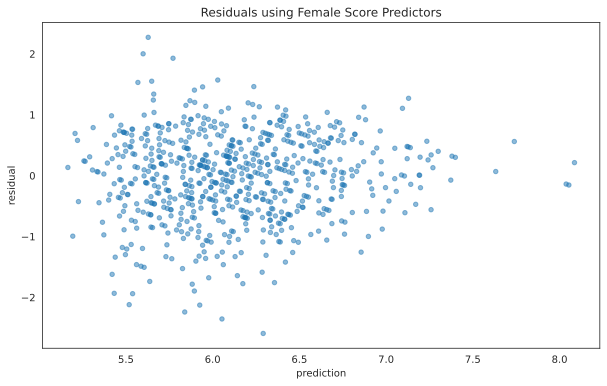

In [21]:
#looking at residuals, checking for outliers 
horror_df['prediction']=pipe.predict(X)
horror_df['residual']=y-horror_df.prediction
with sns.axes_style('white'):
    plot=horror_df.plot(kind='scatter',
                  x='prediction',y='residual',alpha=0.5,figsize=(10,6))
plt.title('Residuals using Female Score Predictors')
plt.savefig('fem_pred_residual_scatter.svg',format='svg')

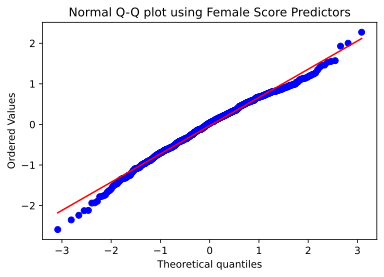

In [22]:
stats.probplot(horror_df['residual'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot using Female Score Predictors")
plt.savefig('Fem_pred_qq.svg',format='svg')
plt.show()


In [23]:
# R-Squared and MAE are my metrics for this project 
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, robust_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, robust_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, robust_pred)))

Mean Absolute Error: 0.5183382409491619


In [24]:
#from yellowbrick.regressor import PredictionError
#visualizer=PredictionError(pipe)
#visualizer.fit(X_train,y_train)
#visualizer.score(X_test,y_test)
#plt.title('Predition Error for Ridge Regression')
#plt.savefig('Fem_Pred_Error.svg',format='svg')
#visualizer.show();

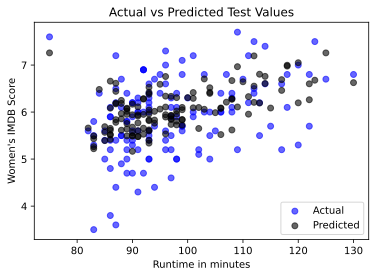

In [25]:
#Comparison of Actual Score vs Score predicted by model
plt.scatter(X_test['Runtime_min'],y_test, color='blue', alpha=0.6,label="Actual") #actual
plt.scatter(X_test['Runtime_min'],robust_pred, color="black", alpha=0.6,label="Predicted") #predicted
plt.title('Actual vs Predicted Test Values')
plt.ylabel("Women's IMDB Score")
plt.xlabel("Runtime in minutes")
plt.legend(); 
plt.savefig('runtime_predicted_actual_scatter.svg',format='svg')

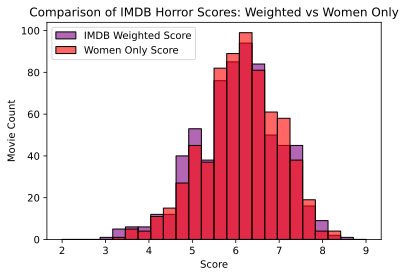

In [26]:
#Comparison of IMDB weighted score and Women's scores
bins=np.linspace(2,9,25)
sns.histplot(horror_df.IMDB_Score,alpha=0.6,color='purple', label='IMDB Weighted Score',bins=bins)
sns.histplot(horror_df.Female_Score,alpha=0.6,color='red',label='Women Only Score',bins=bins)
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Women Only')
plt.legend();
plt.savefig('IMDB_Weighted_Women_hist.svg',format='svg')

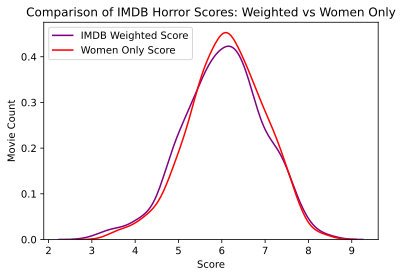

In [27]:
#Comparison of IMDB weighted score and Women's scores kde visualization
bins=np.linspace(2,9,25)
sns.kdeplot(horror_df.IMDB_Score,alpha=0.6,color='purple', label='IMDB Weighted Score')
sns.kdeplot(horror_df.Female_Score,alpha=0.6,color='red',label='Women Only Score')
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Women Only')
plt.legend();
plt.savefig('IMDB_Weighted_Women_kde.svg',format='svg')

In [28]:
#looking at average difference between imdb score and women's score
horror_df['IMDB_Female_Diff']=abs(horror_df['IMDB_Score']-horror_df['Female_Score'])
horror_df['IMDB_Female_Diff'].mean()

0.1736764705882353

In [29]:
horror_df['IMDB_Male_Diff']=abs(horror_df['IMDB_Score']-horror_df['Male_Score'])
horror_df['IMDB_Male_Diff'].mean()

0.04235294117647058

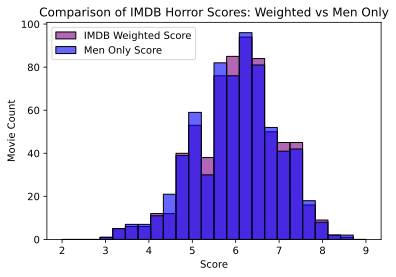

In [30]:
#Comparison of IMDB weighted score and Men's scores
bins=np.linspace(2,9,25)
sns.histplot(horror_df.IMDB_Score,color='purple', alpha=0.6, label='IMDB Weighted Score',bins=bins)
sns.histplot(horror_df.Male_Score,color='blue', alpha=0.6,label='Men Only Score',bins=bins)
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Men Only')
plt.legend();
plt.savefig('IMDB_Weighted_Men_hist.svg',format='svg')

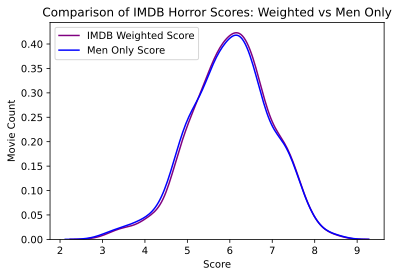

In [31]:
#Comparison of IMDB weighted score and Men's scores kde visualiztion
bins=np.linspace(2,9,25)
sns.kdeplot(horror_df.IMDB_Score,color='purple', alpha=0.6, label='IMDB Weighted Score')
sns.kdeplot(horror_df.Male_Score,color='blue', alpha=0.6,label='Men Only Score')
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Men Only')
plt.legend();
plt.savefig('IMDB_Weighted_Men_kde.svg',format='svg')

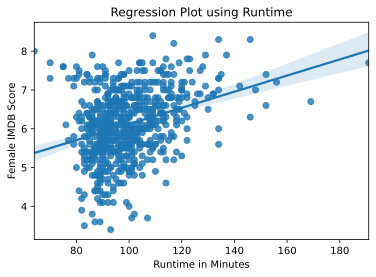

In [32]:
#Regression plot
sns.regplot(x="Runtime_min",y="Female_Score",data=horror_df)
plt.title('Regression Plot using Runtime')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Female IMDB Score');
plt.savefig('Regression_Plot_Runtime_Feature.svg', format='svg')